In [46]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


### Download Denton County data from geojson file and select fields to include in the dataframe

In [47]:
!wget -q -O 'denton_data.json' http://data1-dentontxgis.opendata.arcgis.com/datasets/39888dad239f4ae69796564ae21b5649_0.geojson
print('Data downloaded!')

Data downloaded!


In [48]:
import json
with open('denton_data.json') as json_data:
    denton_data = json.load(json_data)

In [49]:
denton_data = denton_data['features']
denton_data = denton_data[0:10000] #use only 1000 since dataset is huge and will take a long time to parse

In [50]:
# define the dataframe columns
## Not including address in the data
column_names = [ 'Subdivison','appraised','type','city','land','Subdivison_2','area','year','zip','Latitude', 'Longitude'] 

# instantiate the dataframe
denton = pd.DataFrame(columns=column_names)
denton

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude


In [51]:
data = denton_data[0]
latlon = data['geometry']['coordinates'][0][0]
latlon

[-96.8644123766343, 33.2912905587367]

#### Notes
1. Use try for latitude and longitude else it throws an error with 0 values
2. Not to include address in the data
3. Pick only 10k records else it takes a long time to run the loop...(time taken for 10k records = 1.2 minutes)

In [52]:
for data in denton_data:
    Subdivison = data['properties']['ABSTORSU_1'] 
    appraised = data['properties']['APPRAISED']
    type = data['properties']['CD_DESCRIP']
    city = data['properties']['CITY']
    land = data['properties']['LAND_SQFT']
    Subdivison_2 = data['properties']['LEGAL_DESC']
    area = data['properties']['LIVINGAREA']
    year = data['properties']['YR_BLT']
    zip = data['properties']['ZIP']
    try:
        latlon = data['geometry']['coordinates']
        lat = latlon[0][0][1]
        lon = latlon[0][0][0]
    except TypeError:
        lat=0
        lon=0
    denton = denton.append({'Subdivison': Subdivison, 'appraised': appraised, 'type': type,
                                          'city': city, 'land': land, 'Subdivison_2': Subdivison_2,
                                          'area': area, 'year': year,'zip': zip, 'Latitude': lat,
                                           'Longitude': lon}, ignore_index=True)
                                           
                                          
print('done')                         

done


In [53]:
denton.tail()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude
9995,MORNINGSIDE 1,168499,"Real, Residential, Single Family",CARROLLTON,7548,MORNINGSIDE 1 BLK 2 LOT 15,1684,1980,75006,32.9894,-96.8705
9996,RIVER OAKS ADDN PH 3,182000,"Real, Residential, Single Family",CROSSROADS,7607,RIVER OAKS ADDN PH 3 BLK F LOT 11,3063,2001,76227,33.1434,-97.1156
9997,O T JUSTIN,19500,"Real, Vacant, Commercial Lot",FORT WORTH,6500,O T JUSTIN BLK 28 LOT 3 & 10' OF ALLEY,0,0,76117,33.0866,-97.2912
9998,WM. LOVE,7,"Real, Farm and Ranch, Open Space Qualified Land",DALLAS,5009.4,"A0728A WM LOVE, TR 1F, 0.1150 ACRES, (NWISD)(C...",0,0,75287,33.0679,-97.2234
9999,SOUTHRIDGE,237713,"Real, Residential, Single Family",DENTON,16950,SOUTHRIDGE BLK 30 LOT 28,3254,1973,76205,33.1874,-97.1218


### Explore and clean up data

In [10]:
# Count of Records with 0 for living area..most of them are just land with nothing built on it
denton[denton['area']==0].count()

Subdivison      812
appraised       812
type            812
city            812
land            812
Subdivison_2    812
area            812
year            812
zip             812
Latitude        812
Longitude       812
dtype: int64

In [54]:
#drop the records with area = 0
denton = denton[denton['area']!=0]
denton = denton.reset_index(drop = True)
denton.tail()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude
9183,HARRIET CREEK RANCH PH 3,187435,"Real, Residential, Single Family",JUSTIN,5663,HARRIET CREEK RANCH PH 3 BLK 1 LOT 35,3448,2005,76247,33.046,-97.3233
9184,OAK CREEK ESTATES PH 1 (CARROLLTON),381436,"Real, Residential, Single Family",CARROLLTON,14269,OAK CREEK ESTATES PH I (CARROLLTON) BLK A LOT 8,3142,1993,75007,33.0145,-96.8559
9185,MORNINGSIDE 1,168499,"Real, Residential, Single Family",CARROLLTON,7548,MORNINGSIDE 1 BLK 2 LOT 15,1684,1980,75006,32.9894,-96.8705
9186,RIVER OAKS ADDN PH 3,182000,"Real, Residential, Single Family",CROSSROADS,7607,RIVER OAKS ADDN PH 3 BLK F LOT 11,3063,2001,76227,33.1434,-97.1156
9187,SOUTHRIDGE,237713,"Real, Residential, Single Family",DENTON,16950,SOUTHRIDGE BLK 30 LOT 28,3254,1973,76205,33.1874,-97.1218


#### Let us drop all properties which are not Single Family

In [55]:
denton_1 = denton[denton['type'].str.contains('Single Family') == False]
denton_1.tail(10) # clearly we dont need these records for our analysis

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude
9027,PASQUINELLIS PARKER ESTATES PH III,169719,"Real, Residential, Townhomes",ROCKWELL,2501,PASQUINELLIS PARKER ESTATES PH III BLK A LOT 14,1372,2005,75087,33.0458,-96.859
9037,H. WHITE,206328,"Real, Rural, Not Open Space Qualified Land and...",AUBREY,532090,"A1332A H. WHITE, TR 43, 12.2151 ACRES, OLD DCA...",5329,1986,76227,33.2577,-96.9964
9038,JOHN PEARSON,151710,"Real, Commercial",DENTON,22389,"A1048A JOHN PEARSON, TR 9, .514 ACRES, OLD DCA...",1736,1977,76207,33.2866,-96.986
9039,WEAVER MANUFACTURING COMPANY INC ADDN,253657,"Real, Commercial",FLOWER MOUND,152460,WEAVER MANUFACTURING COMPANY INC ADDN BLK A LO...,72880,1991,75028,33.0711,-97.0791
9083,PASQUINELLIS PARKER ESTATES PH II,176230,"Real, Residential, Townhomes",PLANO,2511,PASQUINELLIS PARKER ESTATES PH II BLK E LOT 40,1418,2002,75093,33.0442,-96.8567
9084,SUNFLOWER MEADOWS,59891,"Real, Residential, Mobile Home",JUSTIN,43560,SUNFLOWER MEADOWS BLK 2 LOT 9 SN#1 TXFL512A456...,2280,2005,76247,33.0567,-97.3305
9150,J.S. DICKSON,95560,"Real, Residential, Mobile Home",DENTON,54362.9,"A0342A J.S. DICKSON, TR 27, 1.248 ACRES, SN#1 ...",2368,1992,76210,33.1335,-97.1099
9155,BBB & CRR,185434,"Real, Rural, Not Open Space Qualified Land and...",KRUM,174676,"A0168A BBB & CRR, TR 31B, 4.01 ACRES",3086,2003,76249,33.2399,-97.2572
9160,LAKEWOOD ADDN,416005,"Real, Residential, Waterfront",ARGYLE,45520,LAKEWOOD ADDN BLK A LOT 11,3141,1994,76226,33.1097,-97.0743
9172,FRASHER ADDN,39468,"Real, Rural, Mobile Home on not Open Space Qua...",ARGYLE,178030,FRASHER ADDN BLK 1 LOT 3(OUTSIDE CITY) ACRES 4...,1248,1989,76226,33.0875,-97.1975


In [56]:
denton = denton[denton['type'].str.contains('Single Family') == True]
denton = denton.reset_index(drop = True)
denton.shape[0] #8629 records left

8629

### Check data types to ensure appraised, living area and land area are numeric

In [75]:
denton.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8629 entries, 0 to 8628
Data columns (total 12 columns):
Subdivison      8629 non-null object
appraised       8629 non-null int64
type            8629 non-null object
city            8629 non-null object
land            8629 non-null float64
Subdivison_2    8629 non-null object
area            8629 non-null int64
year            8629 non-null int64
zip             8629 non-null object
Latitude        8629 non-null object
Longitude       8629 non-null object
Age             8629 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 809.0+ KB


In [57]:
denton.appraised = pd.to_numeric(denton.appraised)
denton.land = pd.to_numeric(denton.land)
denton.area = pd.to_numeric(denton.area)
denton.year = pd.to_numeric(denton.year)
#denton.Latitude = pd.to_numeric(denton.Latitude)
#denton.Longitude = pd.to_numeric(denton.Longitude)
denton.head()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude
0,HIGHLAND HILLS SEC 4,250183,"Real, Residential, Single Family",HIGHLAND VILL,16571.0,HIGHLAND HILLS SEC 4 BLK 2 LOT 28,2101,1982,75077,33.0858,-97.0403
1,GARDEN OAK ESTATES PH 1,217192,"Real, Residential, Single Family",LEWISVILLE,7425.0,GARDEN OAK ESTATES PH 1 BLK A LOT 5,1850,1998,75077,33.064,-97.0381
2,HIGHPOINT 1,137285,"Real, Residential, Single Family",LEWISVILLE,7700.0,HIGHPOINT 1 BLK A LOT 45,1614,1980,75077,33.071,-97.0427
3,"STONE HILL FARMS PH 1,2",262000,"Real, Residential, Single Family",FLOWER MOUND,9083.0,"STONE HILL FARMS PH 1,2 SEC I BLK H LOT 9",2712,2000,75028,33.0688,-97.0457
4,TIMBERVIEW ESTATES WEST PH 1 & 2,297769,"Real, Residential, Single Family",FLOWER MOUND,7583.0,"TIMBERVIEW ESTATES WEST PH 1,2 BLK F LOT 28",2989,1999,75028,33.0582,-97.071


### Let's add age of the house

In [58]:
denton['Age'] = 2019 - denton.year
denton.head()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude,Age
0,HIGHLAND HILLS SEC 4,250183,"Real, Residential, Single Family",HIGHLAND VILL,16571.0,HIGHLAND HILLS SEC 4 BLK 2 LOT 28,2101,1982,75077,33.0858,-97.0403,37
1,GARDEN OAK ESTATES PH 1,217192,"Real, Residential, Single Family",LEWISVILLE,7425.0,GARDEN OAK ESTATES PH 1 BLK A LOT 5,1850,1998,75077,33.064,-97.0381,21
2,HIGHPOINT 1,137285,"Real, Residential, Single Family",LEWISVILLE,7700.0,HIGHPOINT 1 BLK A LOT 45,1614,1980,75077,33.071,-97.0427,39
3,"STONE HILL FARMS PH 1,2",262000,"Real, Residential, Single Family",FLOWER MOUND,9083.0,"STONE HILL FARMS PH 1,2 SEC I BLK H LOT 9",2712,2000,75028,33.0688,-97.0457,19
4,TIMBERVIEW ESTATES WEST PH 1 & 2,297769,"Real, Residential, Single Family",FLOWER MOUND,7583.0,"TIMBERVIEW ESTATES WEST PH 1,2 BLK F LOT 28",2989,1999,75028,33.0582,-97.071,20


#### Lets save the dataframe as a pickle file

In [59]:
denton.to_pickle('denton.pkl')

In [60]:

d1 = pd.read_pickle('denton.pkl')
d1.tail()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude,Age
8624,HARRIET CREEK RANCH PH 3,187435,"Real, Residential, Single Family",JUSTIN,5663.0,HARRIET CREEK RANCH PH 3 BLK 1 LOT 35,3448,2005,76247,33.046,-97.3233,14
8625,OAK CREEK ESTATES PH 1 (CARROLLTON),381436,"Real, Residential, Single Family",CARROLLTON,14269.0,OAK CREEK ESTATES PH I (CARROLLTON) BLK A LOT 8,3142,1993,75007,33.0145,-96.8559,26
8626,MORNINGSIDE 1,168499,"Real, Residential, Single Family",CARROLLTON,7548.0,MORNINGSIDE 1 BLK 2 LOT 15,1684,1980,75006,32.9894,-96.8705,39
8627,RIVER OAKS ADDN PH 3,182000,"Real, Residential, Single Family",CROSSROADS,7607.0,RIVER OAKS ADDN PH 3 BLK F LOT 11,3063,2001,76227,33.1434,-97.1156,18
8628,SOUTHRIDGE,237713,"Real, Residential, Single Family",DENTON,16950.0,SOUTHRIDGE BLK 30 LOT 28,3254,1973,76205,33.1874,-97.1218,46


### Data is good. Let's now put it on a map and start exploring
#### Note that folium has trouble generating maps with more than 1000 rows
#### We will take a sample of 1st 100 entries to generate the map

In [61]:
address = 'Denton,TX'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Denton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denton are 33.1838787, -97.1413417.


In [62]:
map_denton = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for i in range(100):
    label = '{}, {}'.format(d1.city[i], d1.Subdivison[i])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [d1.Latitude[i],d1.Longitude[i]],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denton)  
    
map_denton

In [23]:
import matplotlib.pyplot as plt
plt.savefig("figure.png")

### Let's use Age, Living area and Land area for a Subdivison as features to run regression to see what the appraised value of my house should be. Let's chose the subdivison we want to test this on.

In [63]:
d1.Subdivison.value_counts() #Let us test our hypothesis on Lewisville valley Subdivison

LEWISVILLE VALLEY 3                      191
TIMBERCREEK COMM #10B                    163
LEWISVILLE VALLEY 4                      152
TIMBERVIEW ESTATES WEST PH 1 & 2         138
PROVIDENCE PH 1                          115
WESTCHESTER-FLOWER MOUND 2               100
WESTCHESTER-FLOWER MOUND 1                76
GLENWICK EST PH 2                         76
TIMBERVIEW EST PH 1                       72
HIGHPOINT 1                               70
COUNTRY MEADOW ADDN PH I                  65
COUNTRYSIDE EST PH 2                      63
CARRIAGE GLENN AT BRIDLEWOOD              60
LEWISVILLE VALLEY 4 SEC B PH 3            58
EAGLE VILLAGE AT PROVIDENCE PHASE 7       56
TIMBERCREEK COMM #1                       56
TIMBER CREEK PARK ADDN PH 3               55
STEEPLECHASE AT BRIDLEWOOD                55
TIMBER CREEK PARK ADDN PH 6               52
PECAN ACRES                               52
ISLAND VILLAGE AT PROVIDENCE              51
LEWISVILLE VALLEY 4 SEC B PH 1            51
HIDDEN COV

In [64]:
d1_lewisville = d1[d1['Subdivison'].str.contains('LEWISVILLE VALLEY')]
d1_lewisville = d1_lewisville.reset_index(drop = True)
d1_lewisville.head()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude,Age
0,LEWISVILLE VALLEY 5 SEC 3C,171690,"Real, Residential, Single Family",ALLEN,7800.0,LEWISVILLE VALLEY 5 SEC 3C BLK K LOT 25,1797,1985,75013,33.0582,-97.0375,34
1,LEWISVILLE VALLEY 4,142733,"Real, Residential, Single Family",LEWISVILLE,7705.0,LEWISVILLE VALLEY 4 BLK O LOT 22,1555,1985,75077,33.0494,-97.0422,34
2,LEWISVILLE VALLEY 4 SEC B PH 1,139527,"Real, Residential, Single Family",LEWISVILLE,10120.0,LEWISVILLE VALLEY 4 SEC B PH 1 BLK N LOT 36,1575,1984,75067,33.0468,-97.0405,35
3,LEWISVILLE VALLEY 5 SEC 3D,158625,"Real, Residential, Single Family",LEWISVILLE,8619.0,LEWISVILLE VALLEY 5 SEC 3D BLK M LOT 13,1547,1985,75077,33.0599,-97.0364,34
4,LEWISVILLE VALLEY 4 SEC B PH 2A,138531,"Real, Residential, Single Family",LEWISVILLE,7475.0,LEWISVILLE VALLEY 4 SEC B PH 2A BLK J LOT 27,1405,1983,75067,33.045,-97.042,36


In [32]:
d1_lewisville.shape

(559, 12)

### Run scatter plots to see the relationship

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


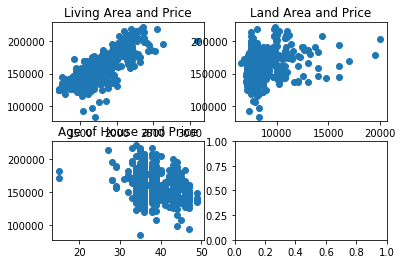

In [65]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows = 2,ncols = 2) #2*2 grid for scatter plots
ax[0,0].scatter(d1_lewisville.area,d1_lewisville.appraised) #scatter plot of living area and space
ax[0,0].set_title("Living Area and Price")
ax[0,1].scatter(d1_lewisville.land,d1_lewisville.appraised)
ax[0,1].set_title("Land Area and Price")
ax[1,0].scatter(d1_lewisville.Age,d1_lewisville.appraised)
ax[1,0].set_title("Age of House and Price")
fig.show()

# Let's run the regression model and see what we get

In [66]:
from sklearn import linear_model
lm = linear_model.LinearRegression() #create a Linear Regression object

x = np.asanyarray(d1_lewisville[['Age','area','land']])
y = np.asanyarray(d1_lewisville['appraised'])

lm.fit(x,y)
lm.coef_

array([ -1.53917392e+03,   6.13883227e+01,   1.28570602e+00])

# Evaluate the model

In [19]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

yhat = lm.predict(x)

r2_score(yhat , y) #Rsquare


0.61487583649001643

## 61% is a good score but not excellent. Let's try KNN Regression and see if we can do better.

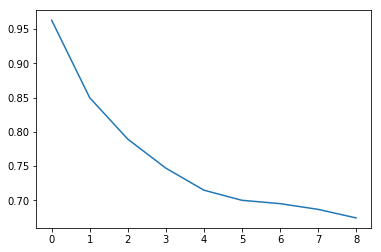

In [20]:
from sklearn.neighbors import KNeighborsRegressor
selector = np.zeros(9)

for i in range(1,10):
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(x, y) 
    selector[i-1] = neigh.score(x,y)
plt.plot(selector)

### Based on the above chart let's use k = 3 for our model which gives us 79% accuracy....Remember we have used only a small sample since it was taking a long time to parse through the records. If we would have used all the data and split in training and test sets we would have seen much better results

### Let's predict the appraised value for a house in Lewsiville Valley with Living Area = 1800 sq ft, Land Area = 7000 sq ft and age = 40 years using both KNN and Linear Regression models.

In [25]:
my_house = np.array([40,1800,7000])
my_house = my_house.reshape(1,-1)
neigh.predict(my_house)


array([ 147633.88888889])

In [171]:
lm.predict(my_house)

array([ 156778.15617197])

## If we look at the closest neighbors both the models are within the range of appraised values but again KNN seems to be doing a better job at predicting the appraised value

In [67]:
d1_neighbors = d1_lewisville[(d1_lewisville.area>=1750) & (d1_lewisville.area<=1850) &\
              (d1_lewisville.land>=6800) & (d1_lewisville.land<=7200)]

d1_neighbors = d1_neighbors.reset_index(drop = True)
d1_neighbors

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zip,Latitude,Longitude,Age
0,LEWISVILLE VALLEY 3,124478,"Real, Residential, Single Family",LEWISVILLE,7130.0,LEWISVILLE VALLEY 3 BLK B LOT 11,1800,1975,75077,33.0516,-97.0444,44
1,LEWISVILLE VALLEY 4,157265,"Real, Residential, Single Family",LEWISVILLE,7080.0,LEWISVILLE VALLEY 4 BLK A LOT 44,1815,1980,75067,33.0445,-97.0369,39
2,LEWISVILLE VALLEY 3,150549,"Real, Residential, Single Family",LEWISVILLE,7130.0,LEWISVILLE VALLEY 3 BLK I LOT 11,1809,1972,75077,33.0502,-97.0415,47
3,LEWISVILLE VALLEY 3,148596,"Real, Residential, Single Family",LEWISVILLE,7130.0,LEWISVILLE VALLEY 3 BLK B LOT 4,1789,1975,75077,33.0502,-97.044,44
4,LEWISVILLE VALLEY 3,148975,"Real, Residential, Single Family",LEWISVILLE,7015.0,LEWISVILLE VALLEY 3 BLK B LOT 6,1808,1975,75077,33.0506,-97.044,44
5,LEWISVILLE VALLEY 3,135905,"Real, Residential, Single Family",MOUND,7130.0,LEWISVILLE VALLEY 3 BLK I LOT 12,1784,1972,55364,33.0502,-97.0413,47
6,LEWISVILLE VALLEY 3,141200,"Real, Residential, Single Family",LEWISVILLE,7130.0,LEWISVILLE VALLEY 3 BLK B LOT 2,1810,1975,75077,33.0501,-97.044,44
7,LEWISVILLE VALLEY 3,140900,"Real, Residential, Single Family",LEWISVILLE,7130.0,LEWISVILLE VALLEY 3 BLK M LOT 25,1797,1973,75077,33.0506,-97.0381,46
8,LEWISVILLE VALLEY 3,146447,"Real, Residential, Single Family",PLANO,7015.0,LEWISVILLE VALLEY 3 BLK H LOT 35,1753,1972,75024,33.0508,-97.0433,47


## Let's plot a map with all the houses in Lewisville Valley

In [68]:
address = 'Lewisville,TX'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Denton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denton are 33.046233, -96.994174.


In [69]:
map_lewisville = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for i in range(d1_lewisville.shape[0]):
    label = '{}, {}'.format(d1_lewisville.city[i], d1_lewisville.Subdivison[i])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [d1_lewisville.Latitude[i],d1_lewisville.Longitude[i]],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lewisville)  
    
map_lewisville

## Nearest Neighbors plot

In [70]:
latitude = d1_neighbors['Latitude'][0]
latitude

33.0515993727368

In [71]:
latitude = d1_neighbors['Latitude'][0]
longitude = d1_neighbors['Longitude'][0]
map_neighbor = folium.Map(location=[latitude, longitude], zoom_start=16.5)

# add markers to map
for i in range(d1_neighbors.shape[0]):
    label = '{}, {}'.format(d1_neighbors.city[i], d1_neighbors.Subdivison[i])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [d1_neighbors.Latitude[i],d1_neighbors.Longitude[i]],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_neighbor)  
    
map_neighbor

# Phase 2: Add Foursquare API data alongwith the prediction tool to help search for potential houses 

In [95]:
CLIENT_ID = 'UAVWDKCJOIFQMEH3XWOYJSGQCWGH0UQZRNUSGZ1Q4UPDZ0RL' # your Foursquare ID
CLIENT_SECRET = 'H1BDGSIFI1HDPT4EWSKDF5XRIO5AHZODM2B333HY12RR0DKU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50

In [82]:
d1_lewisville.rename(columns = {'zip':'zipcode'},inplace = True)
d1_lewisville.head()

,Subdivison,appraised,type,city,land,Subdivison_2,area,year,zipcode,Latitude,Longitude,Age
0,LEWISVILLE VALLEY 5 SEC 3C,171690,"Real, Residential, Single Family",ALLEN,7800.0,LEWISVILLE VALLEY 5 SEC 3C BLK K LOT 25,1797,1985,75013,33.0582,-97.0375,34
1,LEWISVILLE VALLEY 4,142733,"Real, Residential, Single Family",LEWISVILLE,7705.0,LEWISVILLE VALLEY 4 BLK O LOT 22,1555,1985,75077,33.0494,-97.0422,34
2,LEWISVILLE VALLEY 4 SEC B PH 1,139527,"Real, Residential, Single Family",LEWISVILLE,10120.0,LEWISVILLE VALLEY 4 SEC B PH 1 BLK N LOT 36,1575,1984,75067,33.0468,-97.0405,35
3,LEWISVILLE VALLEY 5 SEC 3D,158625,"Real, Residential, Single Family",LEWISVILLE,8619.0,LEWISVILLE VALLEY 5 SEC 3D BLK M LOT 13,1547,1985,75077,33.0599,-97.0364,34
4,LEWISVILLE VALLEY 4 SEC B PH 2A,138531,"Real, Residential, Single Family",LEWISVILLE,7475.0,LEWISVILLE VALLEY 4 SEC B PH 2A BLK J LOT 27,1405,1983,75067,33.045,-97.042,36


## Get the list of nearby venues in Lewisville area

In [99]:
venues_list=[]
for i in range(0,d1_lewisville.shape[0]):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
    results = requests.get(url).json()["response"]['groups'][0]['items']
    venues_list.append([(
            code, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

lewisville_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
lewisville_venues.columns = ['Postalcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [98]:
lewisville_venues.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,33.058157,-97.037459,L.L. Woods Park,33.054946,-97.038809,Park
1,33.058157,-97.037459,Fresh & Creamy Dounts,33.055735,-97.035938,Donut Shop
2,33.058157,-97.037459,CoCo Donuts,33.055418,-97.036057,Donut Shop
3,33.058157,-97.037459,L. L. Woods Disc Golf Course,33.054782,-97.038962,Disc Golf
4,33.049357,-97.042210,Lipsbykris.Com,33.050605,-97.040225,Cosmetics Shop


## Top 10 venue categories in the Lewisville area with their frequency

In [108]:
Venues = lewisville_venues['Venue Category'].value_counts()
Venues.sort_values(ascending = False).head(10)

Cosmetics Shop             336
Park                       204
Gym / Fitness Center       168
American Restaurant        152
Disc Golf                  150
Ice Cream Shop             142
Donut Shop                 130
Health & Beauty Service    127
Restaurant                 115
Coffee Shop                110
Name: Venue Category, dtype: int64